<a href="https://colab.research.google.com/github/MVFran/PyTorchForDeepLearning/blob/master/RedNeuronalConvolucional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# En esta red neuronal, vamos a utilizar la base de datos MNIST
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Convertimos las imagenes de MNIST es un tensor de 4 dimensiones (Número de imágenes, alto, ancho, color)
transform = transforms.ToTensor()

In [3]:
# Cargamos la base de datos
train_data = datasets.MNIST(root = "/CNN_data", train = True, download = True, transform = transform)

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.24MB/s]


Extracting /CNN_data/MNIST/raw/train-images-idx3-ubyte.gz to /CNN_data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 28.9k/28.9k [00:00<00:00, 155kB/s]


Extracting /CNN_data/MNIST/raw/train-labels-idx1-ubyte.gz to /CNN_data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.45MB/s]


Extracting /CNN_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /CNN_data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 4.54k/4.54k [00:00<00:00, 7.88MB/s]


Extracting /CNN_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /CNN_data/MNIST/raw



In [4]:
test_data = datasets.MNIST(root = "/CNN_data", train = False, download = True, transform = transform)

In [5]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /CNN_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /CNN_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [7]:
# Creamos un tamaño del batch para las imágenes (en este caso 10)
train_loader = DataLoader(train_data, batch_size = 10, shuffle = True)
test_loader = DataLoader(test_data, batch_size = 10, shuffle = False)

In [8]:
# Definimos un modelo de CNN de ejemplo
conv1 = nn.Conv2d(1, 6, 3, 1)
conv2 = nn.Conv2d(6, 16, 3, 1)

In [9]:
# Tomamos una unica imágen del dataset
for i, (X_train, y_train) in enumerate(train_data):
  break

In [10]:
X_train.shape

torch.Size([1, 28, 28])

In [11]:
x = X_train.view(1, 1, 28, 28)

In [12]:
# Probamos la primera convolución
x = F.relu(conv1(x)) # Rectified Linear Unit como función de activación
x.shape              # El 1 indica que es una imagen, el 6 es el número de filtros y 26, 26 las nuevas dimensiones de la imagen

torch.Size([1, 6, 26, 26])

In [13]:
# Se hace max pooling
x = F.max_pool2d(x, 2, 2) # Kernel de 2 y stride de 2
x.shape

torch.Size([1, 6, 13, 13])

In [14]:
# Ahora, hacemos la segunda convolución
x = F.relu(conv2(x))
x.shape

torch.Size([1, 16, 11, 11])

In [15]:
# pooling
x = F.max_pool2d(x, 2, 2)
x.shape # El valor se redondea hacia abajo, ya que no podemos inventar datos para redondear hacia arriba

torch.Size([1, 16, 5, 5])

In [16]:
# Ahora vamos a definir formalmente el modelo
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 6, 3, 1) # input, output, kernel, stride
    self.conv2 = nn.Conv2d(6, 16, 3, 1)
    # Fully connected layer
    self.fc1 = nn.Linear(5 * 5 * 16, 120)  # Hay 16 filtros y después de la última capa de max pooling la imagen se reduce a 5, 5 (el valor de 120 es arbitrario, son neuronas simples)
    self.fc2 = nn.Linear(120, 60)   # el 60 es arbitrario
    self.fc3 = nn.Linear(60, 10) # 10 es el número de clases que tenemos (los números del MNIST)

  def forward(self, X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X, 2, 2) # kernel de 2x2 y stride de 2
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X, 2, 2)

    X = X.view(-1, 16 * 5 * 5) # Como es -1, podemos variar el tamaño del batch

    # Fully connected layer
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)
    return F.log_softmax(X, dim = 1)

In [17]:
 # Creamos una instancia de nuestro modelo
 torch.manual_seed(55)
 model = ConvolutionalNetwork()
 model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (fc3): Linear(in_features=60, out_features=10, bias=True)
)

In [18]:
# Función de perdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

In [19]:
import time
start_time = time.time()

epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
  trn_corr = 0
  tst_corr = 0

  for b, (X_train, y_train) in enumerate(train_loader):
    b += 1 # Empezamos el batch en 1
    y_pred = model(X_train) # Nos da las predicciones del entrenamiento (en 2 dimensiones)
    loss = criterion(y_pred, y_train) # compara las predicciones

    predicted = torch.max(y_pred.data, 1)[1] # Añadimos el número de predicciones correctas
    batch_corr = (predicted == y_train).sum() # Cuantos son correctos con este batch especifico
    trn_corr += batch_corr

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if b % 600 == 0:
      print(f"Epoca {i}, Batch {b}, Loss {loss.item()}")

  train_losses.append(loss)
  train_correct.append(trn_corr)

  #test
  with torch.no_grad():
    for b, (X_test, y_test) in enumerate(train_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1] # Predicciones correctas
      tst_corr += (predicted == y_test).sum()

  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)


current_time = time.time()

total_time = current_time - start_time

print(f"Entrenar el modelo tomó {total_time / 60} minutos")

Epoca 0, Batch 600, Loss 0.8000332117080688
Epoca 0, Batch 1200, Loss 0.014056098647415638
Epoca 0, Batch 1800, Loss 0.19615696370601654
Epoca 0, Batch 2400, Loss 0.545016884803772
Epoca 0, Batch 3000, Loss 0.006100490223616362
Epoca 0, Batch 3600, Loss 0.011846446432173252
Epoca 0, Batch 4200, Loss 0.261645644903183
Epoca 0, Batch 4800, Loss 0.00020967978343833238
Epoca 0, Batch 5400, Loss 0.0005648492951877415
Epoca 0, Batch 6000, Loss 0.0002561464789323509
Epoca 1, Batch 600, Loss 0.08769838511943817
Epoca 1, Batch 1200, Loss 0.03837572783231735
Epoca 1, Batch 1800, Loss 0.002070689806714654
Epoca 1, Batch 2400, Loss 0.029039647430181503
Epoca 1, Batch 3000, Loss 0.03945043683052063
Epoca 1, Batch 3600, Loss 0.15563686192035675
Epoca 1, Batch 4200, Loss 0.002917021047323942
Epoca 1, Batch 4800, Loss 0.003329893108457327
Epoca 1, Batch 5400, Loss 0.09413498640060425
Epoca 1, Batch 6000, Loss 0.7808905839920044
Epoca 2, Batch 600, Loss 0.3457917869091034
Epoca 2, Batch 1200, Loss 0.73

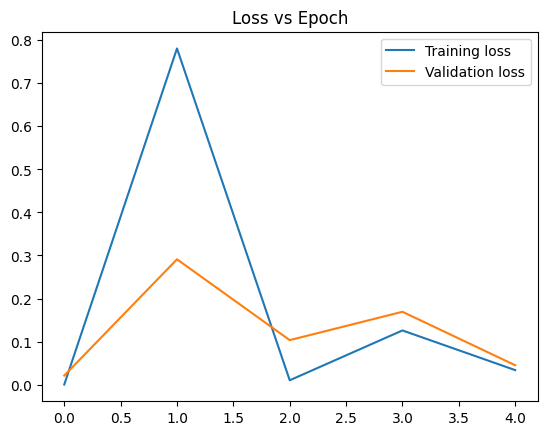

In [20]:
# Graficamos la perdida por epoca
train_losses = [tl.item() for tl in train_losses]

plt.plot(train_losses, label = "Training loss")
plt.plot(test_losses, label = "Validation loss")
plt.title("Loss vs Epoch")
plt.legend()

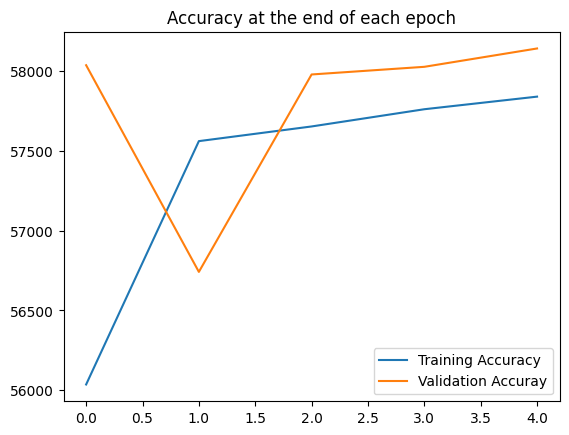

In [24]:
# Graficamos la precisión al final de cada epoca
plt.plot([t for t in train_correct], label = "Training Accuracy")
plt.plot([t for t in test_correct], label = "Validation Accuray")
plt.title("Accuracy at the end of each epoch")
plt.legend()

In [25]:
test_load_everything = DataLoader(test_data, batch_size = 10000, shuffle = False)

In [26]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_everything:
    y_val = model(X_test)
    predicted = torch.max(y_val, 1)[1]
    correct += (predicted == y_test).sum()

In [28]:
correct.item()/len(test_data)*100

96.89

In [30]:
# Tomamos una imagen
test_data[4143] # Es un tensor correspondiente a una imagen, y al final del mismo se muestra el número asociado

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [31]:
# Ahora, tomamos unicamente los datos
test_data[4143][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [32]:
# Reescalamos la imagen
test_data[4143][0].reshape(28, 28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

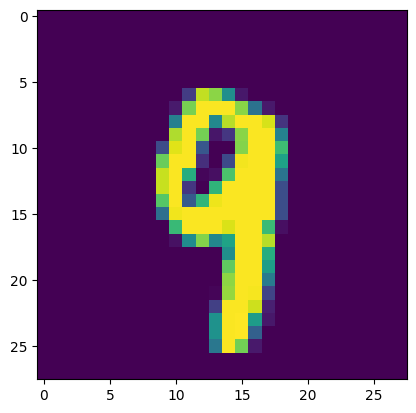

In [33]:
# Veamos la imagen
plt.imshow(test_data[4143][0].reshape(28, 28))

In [34]:
# Pasamos la imagen en el modelo
model.eval()
with torch.no_grad():
  new_prediction = model(test_data[4143][0].view(1, 1, 28, 28)) # Tamaño del batch de 1, 1 canal de color y 28x28 tamaño de la imagen

In [35]:
new_prediction

tensor([[-1.3566e+01, -1.5868e+01, -1.5475e+01, -1.0599e+01, -7.9161e+00,
         -7.7789e+00, -1.7009e+01, -8.8472e+00, -5.0438e+00, -7.4304e-03]])

In [37]:
new_prediction.argmax() # Nos va a indicar la predicción de la red

tensor(9)